In [70]:
from scipy.io import arff
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb
import numpy as np
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns

from meta_learning import MetaLearner, PerformanceEvaluator, Model

import warnings
warnings.filterwarnings('ignore')

In [2]:
f = open("datasets/real/elec.arff", "r")
data, meta = arff.loadarff(f)

df = pd.DataFrame(data)
df['weekday'] = pd.to_numeric(df['day'])
df['class'] = df['class'].str.decode("utf-8")
df = df.drop(['date', 'period', 'day'], axis=1)

print(df.shape)
df.head()

(45312, 7)


,nswprice,nswdemand,vicprice,vicdemand,transfer,class,weekday
0,0.056443,0.439155,0.003467,0.422915,0.414912,UP,2
1,0.051699,0.415055,0.003467,0.422915,0.414912,UP,2
2,0.051489,0.385004,0.003467,0.422915,0.414912,UP,2
3,0.045485,0.314639,0.003467,0.422915,0.414912,UP,2
4,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,2


In [3]:
n = df.shape[0]
class_weight = df['class'].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'DOWN': 0.5754546257062146, 'UP': 0.4245453742937853}

In [4]:
# Macros

CLASS_COL = 'class'

OFFLINE_PHASE_SIZE = 10000
BASE_TRAIN_SIZE = 7000
META_TRAIN_SIZE = 0.5
R_STATE = 123

OMEGA = 300  # Window size with known label
ETA = 100  # Window size with unlabeled examples
STEP = 10

In [5]:
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
validation_df = online_df.iloc[:int(OFFLINE_PHASE_SIZE*META_TRAIN_SIZE)]

## Fase offline

In [71]:
base_model = Model(basis_model=RandomForestClassifier, hyperparameters={'max_depth': 6, 'warm_start': True, 'min_samples_split': 0.05})
meta_model = Model(basis_model=ltb.LGBMRegressor, hyperparameters={'num_leaves': 21, 'max_depth': 6})

learner = MetaLearner(
    base_model=base_model,
    meta_model=meta_model,
    base_model_class_column=CLASS_COL,
    omega=OMEGA,
    eta=ETA,
    step=STEP,
    )

learner.offline_stage(offline_df)

# Experiments

In [62]:
validation_base = learner._get_offline_metabase(validation_df)

In [8]:
def plot_results(y, predicted_y, title, idx, subplot_index=(3, 3)):
    r2 = performance.evaluate(y, predicted_y, 'r2')
    mse = performance.evaluate(y, predicted_y, 'mse')
    std = np.std(y - predicted_y)
    x = range(len(y))

    plt.subplot(*subplot_index, idx + 1)
    plt.plot(x, y, label="expected")
    plt.plot(x, predicted_y, label="predicted")
    plt.title(title)
    plt.legend()

    return {'r2': r2, 'mse': mse, 'std': std}

def offline_train(update_params):
    learner._update_params(**update_params)
    learner.meta_base = learner._get_last_performances(learner.meta_base)
    learner._train_meta_model()

    model = learner.meta_model
    metric = learner.meta_label_metric
    val_base = learner._get_last_performances(validation_base)

    X, y_true = val_base.drop(learner.performance_metrics, axis=1), val_base[metric]
    y_pred = model.predict(X)
    return y_true, y_pred

## Delay

In [65]:
performance = PerformanceEvaluator()
fig = plt.figure(figsize=(25, 10))
delays = range(1, 9)
results = []

update_params={'last_scores_delay': 0, 'last_scores_n_shifts': 0, 'meta_label_metric': 'precision' }
y_true, y_pred = offline_train(update_params)
result = plot_results(y_true, y_pred, title='Sem últimas performances', idx=0)
result['delay'] = 'N/A'
results.append(result)

for idx, delay in enumerate(delays):
    update_params={'last_scores_delay': delay, 'last_scores_n_shifts': 3, 'meta_label_metric': 'precision' }
    y_true, y_pred = offline_train(update_params)
    result = plot_results(y_true, y_pred, title=f"Delay={delay * STEP}", idx=idx+1)
    result['delay'] = delay * STEP
    results.append(result)

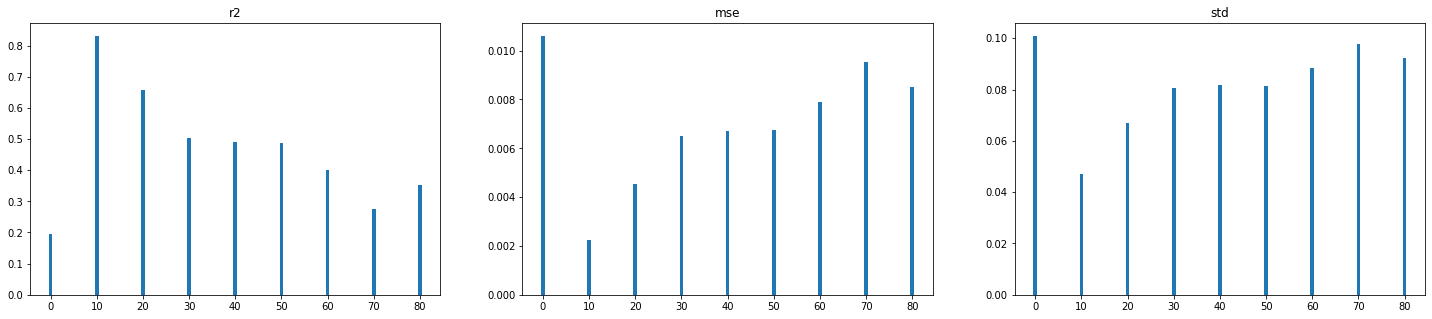

In [10]:
delay_results = pd.DataFrame(results)
fig = plt.figure(figsize=(25, 5))

for idx, col in enumerate(['r2', 'mse', 'std']):
    plt.subplot(1, 3, idx + 1)
    sns.barplot(x="delay", y=col, data=delay_results)
    plt.title(col)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

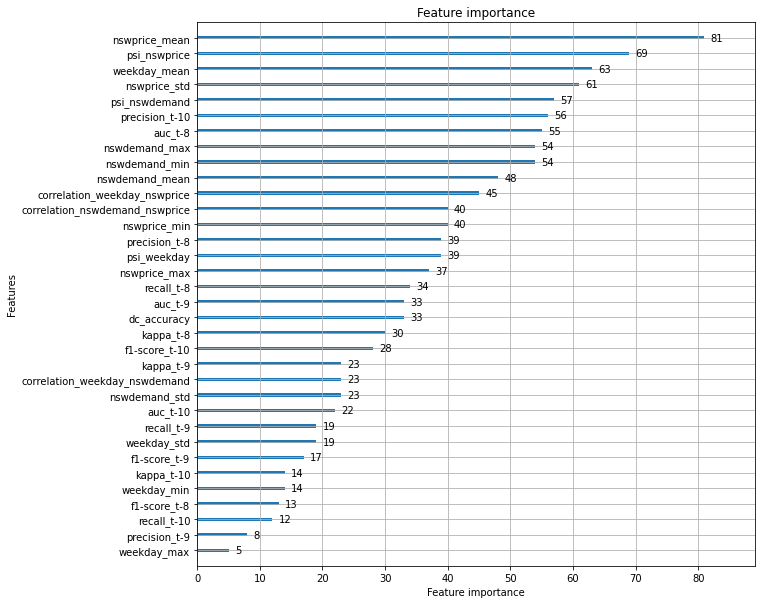

In [11]:
model = learner.meta_model.model
lightgbm.plot_importance(model, figsize=(10, 10))

## Outras métricas

In [12]:
results = []

In [13]:
# BASELINE

for metric in performance.clf_metrics:
    y_true = learner.meta_base[metric]
    y_pred = [np.mean(y_true)] * len(y_true)
    r2 = performance.evaluate(y_true, y_pred, 'r2')
    mse = performance.evaluate(y_true, y_pred, 'mse')
    std = performance.evaluate(y_true, y_pred, 'std')
    results.append({'r2': r2, 'mse': mse, 'std': std, 'type': 'baseline', 'metric': metric})

pd.DataFrame(results)

,r2,mse,std,type,metric
0,0.0,0.022719,0.150729,baseline,precision
1,0.0,0.021719,0.147373,baseline,recall
2,0.0,0.009798,0.098985,baseline,f1-score
3,0.0,0.010173,0.100863,baseline,auc
4,0.0,0.042510,0.206180,baseline,kappa


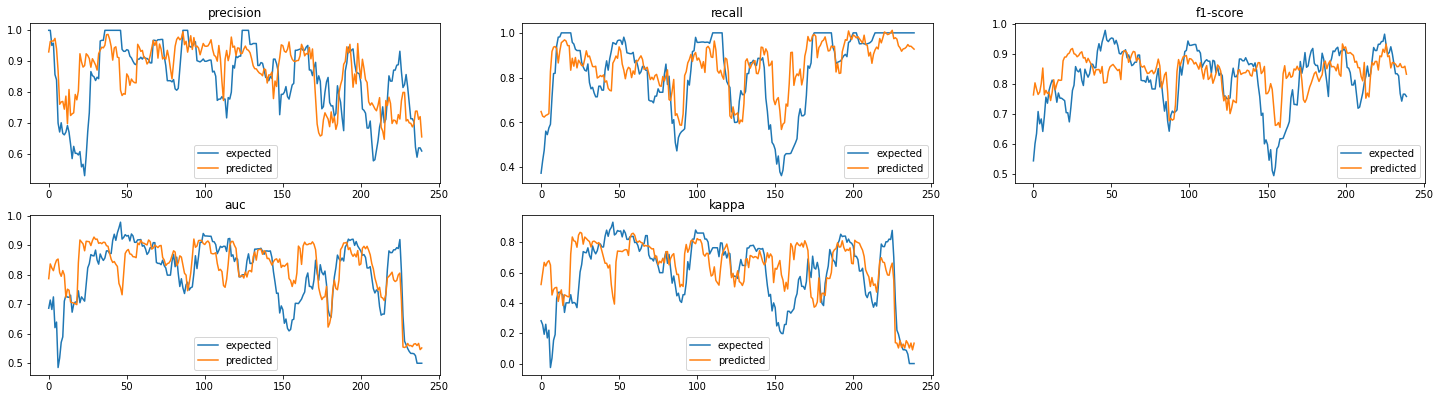

In [14]:
models = {}
fig = plt.figure(figsize=(25, 10))

for idx, metric in enumerate(performance.clf_metrics):
    update_params={'last_scores_delay': 3, 'last_scores_n_shifts': 0, 'meta_label_metric': metric }
    y_true, y_pred = offline_train(update_params)
    result = plot_results(y_true, y_pred, title=metric, idx=idx)
    models[metric] = learner.meta_model.model
    
    result = {**result, **{'type': 'meta learning', 'metric': metric}}
    results.append(result)

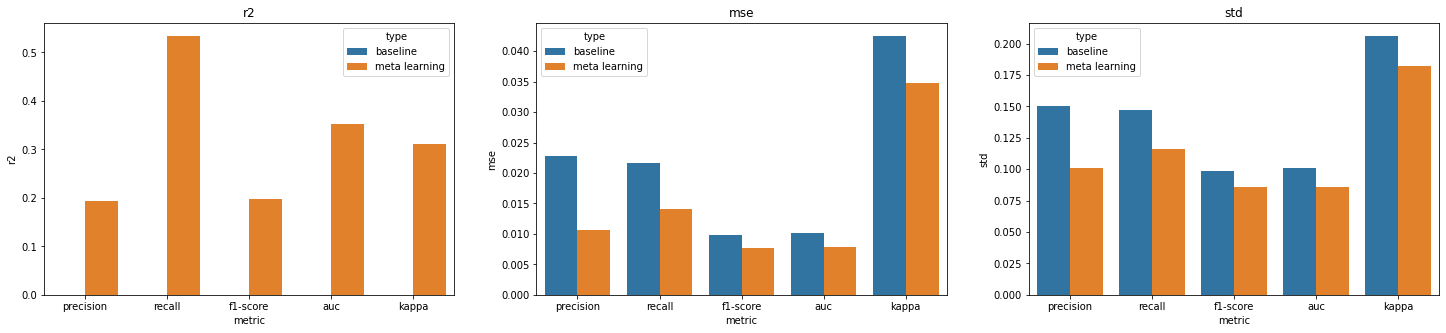

In [33]:
results_metrics = pd.DataFrame(results)
fig = plt.figure(figsize=(25, 5))

for idx, col in enumerate(['r2', 'mse', 'std']):
    plt.subplot(1, 3, idx + 1)
    sns.barplot(x="metric", hue="type", y=col, data=results_metrics)
    plt.title(col)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

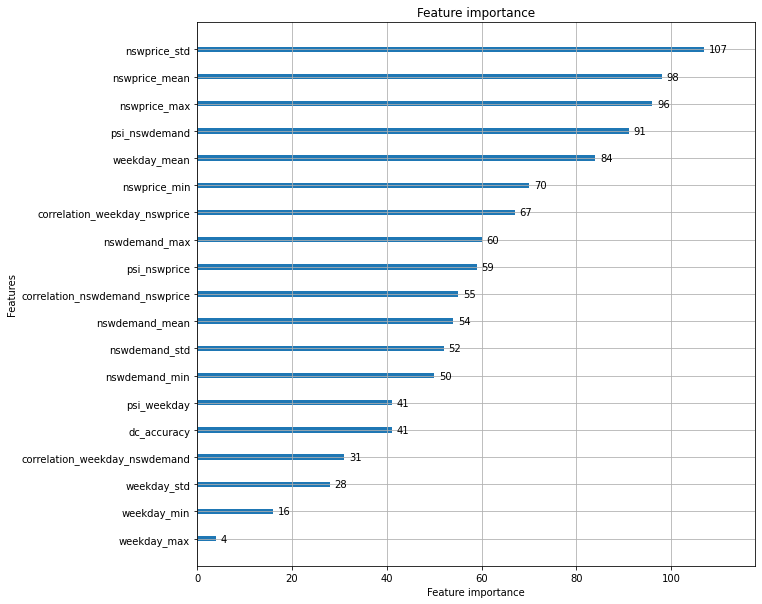

In [15]:
metric = 'precision'
lightgbm.plot_importance(models[metric], figsize=(10, 10))

## Outros base models

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

MODEL_LIST = [
    {'name': 'logistic_regression', 'type': LogisticRegression, 'hyperparameters': {'random_state': R_STATE}},
    {'name': 'random_forest', 'type': RandomForestClassifier, 'hyperparameters': {'random_state': R_STATE, 'max_depth': 6}},
    {'name': 'svm', 'type': SVC, 'hyperparameters': {'random_state': R_STATE}},
    {'name': 'decision_tree', 'type': DecisionTreeClassifier, 'hyperparameters': {'random_state': R_STATE, 'max_depth': 6}},
]

In [95]:
learners = {}

for model in MODEL_LIST:
    base_model = Model(basis_model=model['type'], hyperparameters=model['hyperparameters'])
    meta_model = Model(basis_model=ltb.LGBMRegressor, hyperparameters={'num_leaves': 21, 'max_depth': 6})

    learner = MetaLearner(
        base_model=base_model,
        meta_model=meta_model,
        base_model_class_column=CLASS_COL,
        meta_label_metric='precision',
        omega=OMEGA,
        eta=ETA,
        step=STEP,
        last_scores_delay=3,
        last_scores_n_shifts=3,
        )

    learner.offline_stage(offline_df)
    learners[model['name']] = learner

In [96]:
# BASELINE
results = []

metric = learner.meta_label_metric

# for metric in performance.clf_metrics:
y_true = learner.meta_base[metric]
y_pred = [np.mean(y_true)] * len(y_true)
r2 = performance.evaluate(y_true, y_pred, 'r2')
mse = performance.evaluate(y_true, y_pred, 'mse')
std = performance.evaluate(y_true, y_pred, 'std')
results.append({'r2': r2, 'mse': mse, 'std': std, 'model': 'baseline'})

pd.DataFrame(results)

,r2,mse,std,model
0,0.0,0.029377,0.171398,baseline


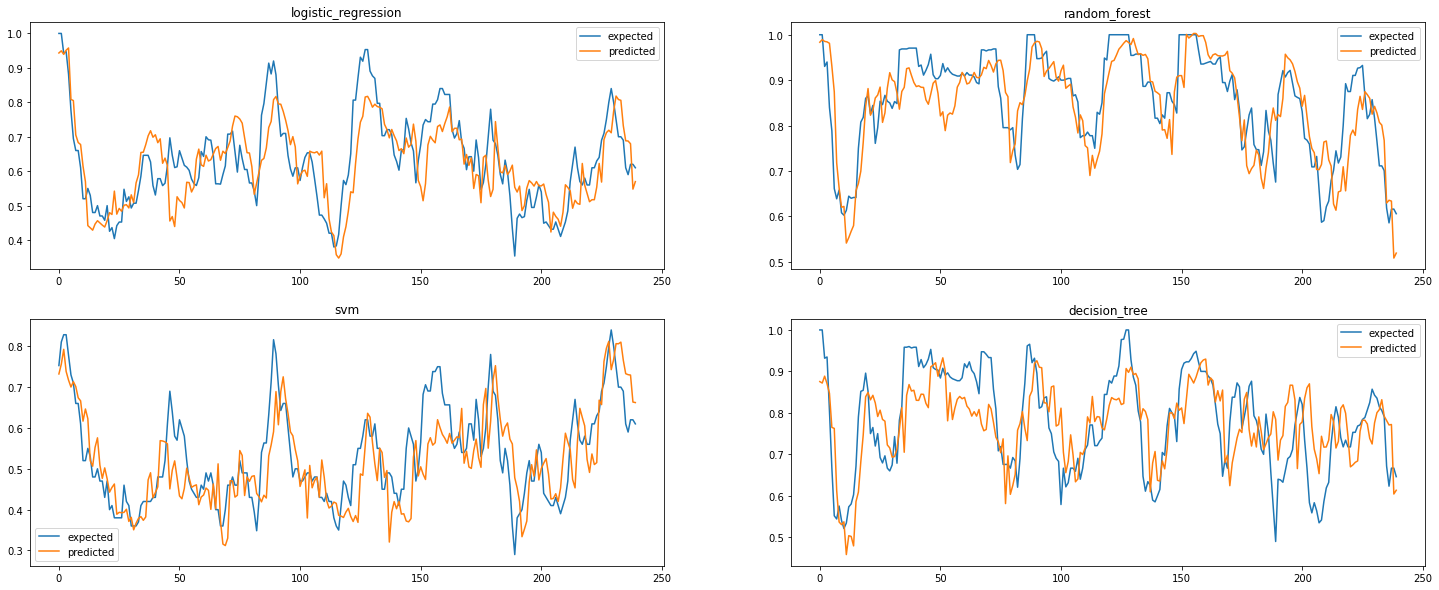

In [97]:
fig = plt.figure(figsize=(25, 10))
model_dict = {}
idx = 0

for model_name, learner in learners.items():
    metric = learner.meta_label_metric
    val_base = learner._get_offline_metabase(validation_df)
    model = learner.meta_model

    X, y_true = val_base.drop(learner.performance_metrics, axis=1), val_base[metric]
    y_pred = model.predict(X)

    result = plot_results(y_true, y_pred, title=model_name, idx=idx, subplot_index=(2, 2))
    model_dict[model_name] = learner.meta_model.model
    idx += 1

    result = {**result, **{'model': model_name}}
    results.append(result)

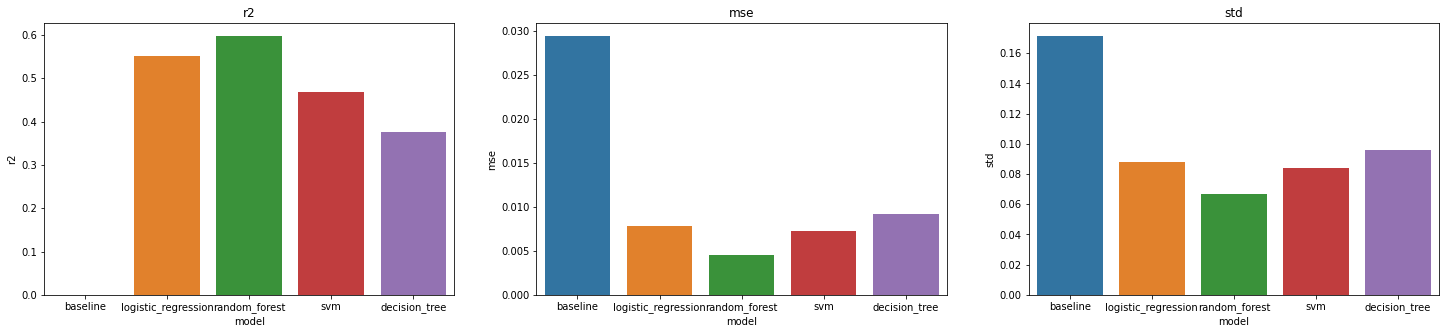

In [98]:
results_models = pd.DataFrame(results)
fig = plt.figure(figsize=(25, 5))

for idx, col in enumerate(['r2', 'mse', 'std']):
    plt.subplot(1, 3, idx + 1)
    sns.barplot(x="model", y=col, data=results_models)
    plt.title(col)

## Testing SVM recall

In [94]:
from sklearn import preprocessing

base_model = SVC(random_state=R_STATE)

base_train_df = offline_df.iloc[:int(OFFLINE_PHASE_SIZE*META_TRAIN_SIZE)]
X_train, y_train = base_train_df.drop(CLASS_COL, axis=1), base_train_df[CLASS_COL]
y_train = preprocessing.LabelEncoder().fit_transform(y_train)

X_test, y_test = validation_df.drop(CLASS_COL, axis=1), validation_df[CLASS_COL]
y_test = preprocessing.LabelEncoder().fit_transform(y_test)

base_model = base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

In [91]:
results_test = []

upper_bound = y_test.shape[0] -  ETA

for t in range(0, upper_bound, STEP):
    result = {}
    window_y_test = y_test[t:t + ETA]
    window_y_pred = y_pred[t:t + ETA]
    for metric in performance.clf_metrics:
        metric_val = performance.evaluate(window_y_test, window_y_pred, metric)
        result[metric] = metric_val
        
    results_test.append(result)
pd.DataFrame(results_test)

,precision,recall,f1-score,auc,kappa
0,0.378378,1.0,0.549020,0.680556,0.240423
1,0.378378,1.0,0.549020,0.680556,0.240423
2,0.405405,1.0,0.576923,0.685714,0.261745
3,0.472973,1.0,0.642202,0.700000,0.318182
4,0.432432,1.0,0.603774,0.691176,0.283765
...,...,...,...,...,...
485,0.610000,1.0,0.757764,0.500000,0.000000
486,0.590000,1.0,0.742138,0.500000,0.000000
487,0.620000,1.0,0.765432,0.500000,0.000000
488,0.620000,1.0,0.765432,0.500000,0.000000


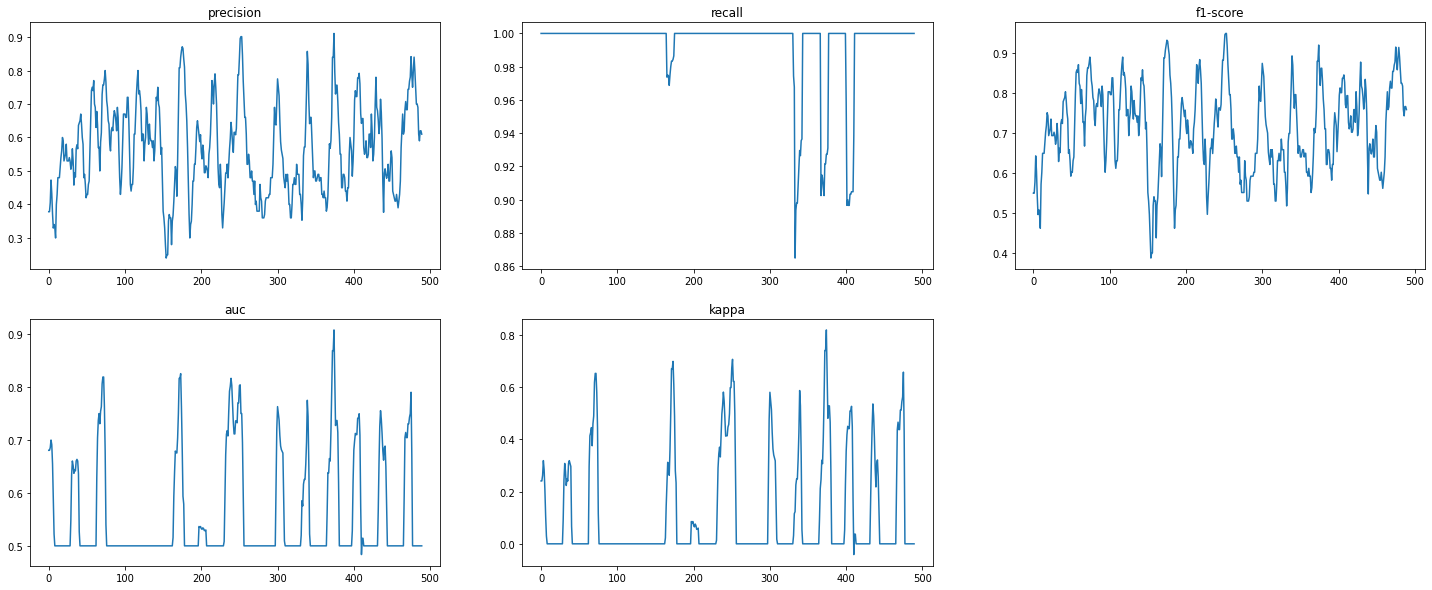

In [93]:
results_models = pd.DataFrame(results_test)
fig = plt.figure(figsize=(25, 10))

for idx, col in enumerate(results_models.columns):
    plt.subplot(2, 3, idx + 1)
    plt.plot(results_models[col])
    plt.title(col)